# Session 9: Introduction to Support Vector Machines

------------------------------------------------------
Introduction to Data Science & Machine Learning

*Pablo M. Olmos olmos@tsc.uc3m.es*

------------------------------------------------------


[Support vector machines (SVMs)](http://scikit-learn.org/stable/modules/svm.html) are a particularly powerful and flexible class of supervised algorithms for both classification and regression.
In this section, we will develop the intuition behind support vector machines and their use in classification problems.

Recommended Bibliography:

- Chapter 7 of Pattern Recognition and Machine Learning, Christopher Bishop, 2006
- Chapter 17 of [Bayesian Reasoning and Machine Learning](http://web4.cs.ucl.ac.uk/staff/D.Barber/textbook/090310.pdf), David Barber, 2010
- Chapter 14 of Machine Learning: a probabilistic perspective, Kevin Murphy 2012
- This excellent [post](http://efavdb.com/svm-classification/) by Andrew Ng. 

We begin with the standard imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


# use seaborn plotting defaults
import seaborn as sns; sns.set()

Consider the simple case of a classification task, in which the two classes of points are well separated. Check out first what the [make blobs](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) function does.

Also, to learn about color maps in matplotlib check [here](https://matplotlib.org/users/colormaps.html)

The shape of X is  (50, 2)
y is a label vector. The first 10 labels are: [1 1 1 0 1 1 0 1 0 0]


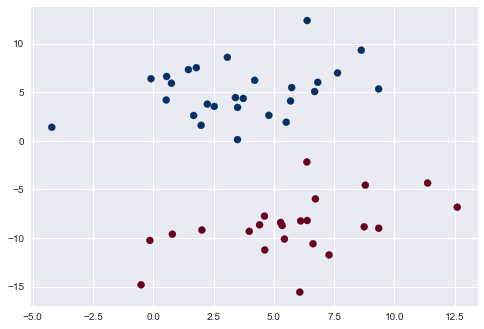

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=10, cluster_std=3)    #With random_state we fix the random seed

#We separate away some data for test
X_test = X[50:-1,:] 
y_test = y[50:-1]

X = X[:50,:]
y = y[:50]

print("The shape of X is ",X.shape)

print("y is a label vector. The first 10 labels are:", y[:10])

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')

plt.rcParams["figure.figsize"] = [8,8]


A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification. ** However, note there are many possible solutions!! **


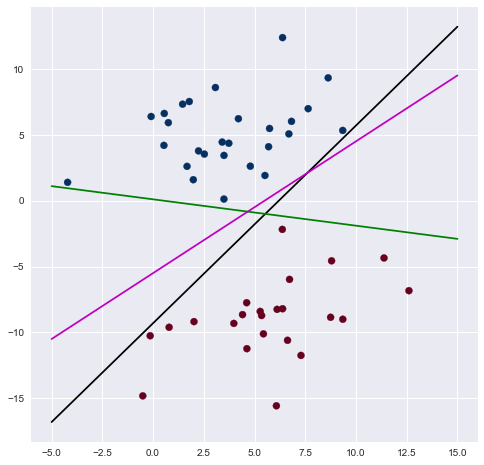

In [3]:
xfit = np.linspace(-5, 15)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')

m,b = (1.5, -9.3)
plt.plot(xfit, m * xfit + b, '-k')

m,b = (1, -5.5)
plt.plot(xfit, m * xfit + b, '-m')

m,b = (-0.2,0.1)
plt.plot(xfit, m * xfit + b, '-g')

plt.rcParams["figure.figsize"] = [8,8]

** Which one do you think separates best the data? **

Lets plot some *test data* with the right category.

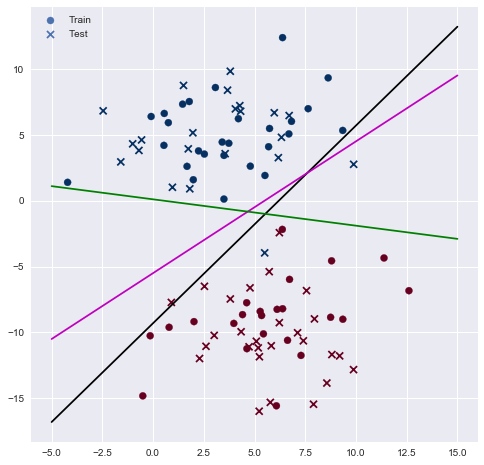

In [4]:
xfit = np.linspace(-5, 15)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu',label='Train')

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap='RdBu',marker='x',label='Test')

plt.legend()

m,b = (1.5, -9.3)
plt.plot(xfit, m * xfit + b, '-k')

m,b = (1, -5.5)
plt.plot(xfit, m * xfit + b, '-m')

m,b = (-0.2,0.1)
plt.plot(xfit, m * xfit + b, '-g')

plt.rcParams["figure.figsize"] = [8,8]

# Maximizing the *Margin*

Support vector machines offer one way to improve on this.
The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point. The largest the margin is, the more robust the model is and generalizes better.

Here is an example of how this might look:

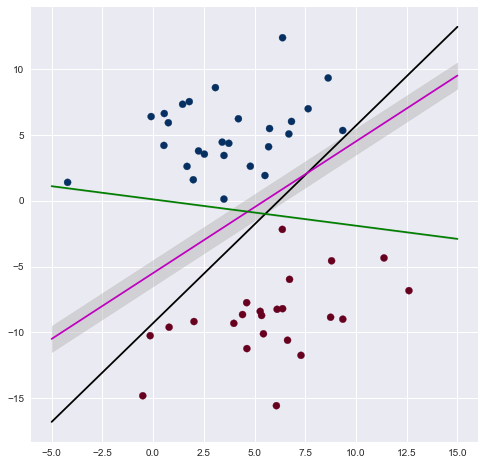

In [5]:
xfit = np.linspace(-5, 15)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')


m,b,d = (1.5, -9.3,0.01)
yfit = m * xfit + b
plt.plot(xfit,yfit, '-k')
plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',color='#AAAAAA', alpha=0.4)

m,b,d = (1, -5.5,1)
yfit = m * xfit + b
plt.plot(xfit,yfit, '-m')
plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',color='#AAAAAA', alpha=0.4)


m,b,d = (-0.2,0.1,0.05)
yfit = m * xfit + b
plt.plot(xfit,yfit, '-g')
plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',color='#AAAAAA', alpha=0.4)

plt.rcParams["figure.figsize"] = [8,8]

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model.
Support vector machines are an example of such a *maximum margin* estimator.

# A little bit of geometry: hyperplanes

### Hyperplanes

First of all, for $\mathbf{x}\in\mathbb{R}^D$, consider the function
\begin{align}
y(\mathbf{x}) = \mathbf{w}^T\mathbf{x}+w_0
\end{align}

Then, the set of points $\mathbf{x}\in\mathbb{R}^D$ such that $y(\mathbf{x})=0$ is called an [**hyperplane**](http://mathworld.wolfram.com/Hyperplane.html), a subspace of dimension $D-1$. E.g., for $D=2$, then the hyperplan is a line. For $D=3$ is a plane.

#### Some useful results with hyperplanes

A) If $\mathbf{x}_A$ and $\mathbf{x}_B$ are two points in the hyperplane, then the vector $\mathbf{v}=\alpha(\mathbf{x}_A-\mathbf{x}_B)$ is *orthogonal* to $\mathbf{w}$ for $\alpha\in\mathbb{R}$. Thus, $\mathbf{w}$ is orthogonal to any vector **contained** in the hyperplane.


B) The normal distance between the origin $\mathbf{0}$ and the closest point in the hyperplane is given by $-\frac{w_0}{||\mathbf{w}||_2}$, where a negative distance denotes that the hyperplane lies below the origin, and $||\mathbf{w}||_2=\sqrt{\mathbf{w}^T\mathbf{w}}$.

C) The normal distance to any point $\mathbf{x}^*\in\mathbb{R}^D$ to the hyperplane is 
\begin{align}
\frac{y(\mathbf{x}^*)}{||\mathbf{w}||_2}
\end{align}
This distance is positive for points **above** the hyperplane, and negative for points **below** the hyperplane.

#### Some useful results with hyperplanes (Proofs)

*Proof for A):* if $\mathbf{x}_A$ and $\mathbf{x}_B$ are two points in the hyperplane, then $\mathbf{w}^T\mathbf{x}_A+w_0=\mathbf{w}^T\mathbf{x}_B+w_0=0$. Thus, $\mathbf{w}^T\left(\mathbf{x}_A-\mathbf{x}_B\right)=0$.

*Proof for B):* Note that, for any $\mathbf{x}$ (not necesarily in the hyperplane), the projection of $\mathbf{x}$ into $\mathbf{w}$ is 
\begin{align}
\frac{ \mathbf{w}^T\mathbf{x}}{||\mathbf{w}||_2} = \frac{||\mathbf{w}||_2||\mathbf{x}||_2\cos(\phi)}{||\mathbf{w}||_2}=||\mathbf{x}||_2\cos(\phi),
\end{align}
where $\phi$ is the angle between $\mathbf{x}$ and $||\mathbf{w}||_2$. Note that this projection is the normal distance between the $\mathbf{0}$ point and the hyperplane orthogonal to $ ||\mathbf{w}||_2$ that passes through $\mathbf{x}$.

Further, if $\mathbf{x}$ belongs to the hyperplane $y(\mathbf{x}) = \mathbf{w}^T\mathbf{x}+w_0$, then   
\begin{align}
||\mathbf{x}||_2\cos(\phi) = -\frac{w_0}{||\mathbf{w}||_2}
\end{align}

*Proof for C) Given any point $\mathbf{x}$ in the hyperplane $y(\mathbf{x}) = \mathbf{w}^T\mathbf{x}+w_0=0$, the normal distance of $\mathbf{x}^*$ to the hyperplane is the proyection of $(\mathbf{x}^*-\mathbf{x})$ into $\mathbf{w}$ (since $\mathbf{w}$ is perpedincular to the plane). Hence
\begin{align}
\text{distance} = \frac{\mathbf{w}^T(\mathbf{x}^*-\mathbf{x})}{||\mathbf{w}||_2}=\frac{\mathbf{w}^T\mathbf{x}-\mathbf{w}^T\mathbf{x}^*}{||\mathbf{w}||_2}=\frac{\mathbf{w}^T\mathbf{x}^*-\mathbf{w}^T\mathbf{x}}{||\mathbf{w}||_2}=\frac{\mathbf{w}^T\mathbf{x}^*+w_0}{||\mathbf{w}||_2}=\frac{y(\mathbf{x}^*)}{||\mathbf{w}||_2}
\end{align}

# Support Vector Machines

Assume there exists an hyperplane that separates our data ** in a transformed space** $\mathcal{D}=(\phi(\mathbf{x})^{(i)},t^{(i)})$, $i=1,\ldots,N$, where $\mathbf{x}\in\mathbb{R}^D$ and $t^{(i)}\in\{-1,+1\}$. Then, there must exist an hyperplane $y(\mathbf{x}) = \mathbf{w}^T\phi(\mathbf{x})+w_0=0$ that verifies
\begin{align}
t^{(i)}y(\mathbf{x}^{(i)})\geq 0, ~~ \forall (\mathbf{x}^{(i)},t^{(i)})
\end{align}

## The SVM: maximizing the margin

The SVM optimization problem reads as follows

\begin{align}
\arg\max_{\mathbf{w},w_0} \left\{ \min_{i} \frac{t^{(i)}y(\mathbf{x}^{(i)})}{||\mathbf{w}||_2}\right\}
\end{align}

However, this can be written in a simpler way. Since the distance of any point $\mathbf{x}^{(i)}$ to the hyperplane is invariant to a scale of the form $\mathbf{w}\leftarrow \eta\mathbf{w}$, $w_0\leftarrow\eta w_0$, **then we can freely set the minimum distance to the hyperplane to $||\mathbf{w}||_2$**, rescaling the whole problem. Thus, any point in the training set must verify

\begin{align}
t^{(i)}y(\mathbf{x}^{(i)})\geq 1, ~~ \forall (\mathbf{x}^{(i)},t^{(i)})
\end{align}

And the equivalent problem can be written follows:

\begin{align}
&\min_{\mathbf{w},w_0} = \frac{1}{2} ||\mathbf{w}||^2_2\\
&\text{subject to}
&t^{(i)}y(\mathbf{x}^{(i)})\geq 1, ~ i=1,\ldots,N
\end{align}

where we have introduced $||\mathbf{w}||^2_2$ as objective function and the factor $\frac{1}{2}$ for later convenience. This optimization problem is an example of a [**Quadratic Programming (QP)**](https://sites.math.washington.edu/~burke/crs/408f/notes/qp/qp1.pdf) optimization problem. Very efficient solvers are known for these kind of problems. Complexity scales cubic in the input dimension, i.e., $\mathcal{O}(D^3)$.

Lets visualize the solution for our running example.

In [6]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)   # We use a linear kernel (no transformation).
                                       # Also, we explain below the role of C
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

The following function plots the SVM decision boundaries for us:

In [7]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:            #If no figure handle is provided, it opens the current figure
        ax = plt.gca()
        
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)    #30 points in the grid axis
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)                 # We create a grid with the x,y coordinates defined above
    
    # From the grid to a list of (x,y) values. 
    # Check Numpy help for ravel()
    
    xy = np.vstack([X.ravel(), Y.ravel()]).T 
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    # In levels we provide a list of floating point numbers indicating 
    #the level curves to draw, in increasing order; e.g., to draw just the zero contour pass
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, marker='p')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

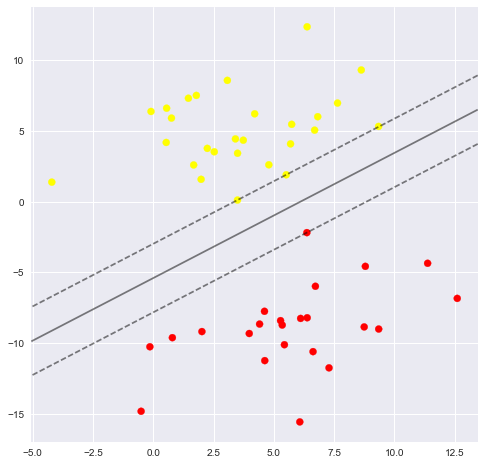

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model,plot_support=False)


plt.rcParams["figure.figsize"] = [8,8]

# Understanding the SVM solution:  kernels and the dual problem

There's lot more that we can say about how SVM perform. To this end, we have to go deeper into the optimization problem itself:

\begin{align}
&\min_{\mathbf{w},w_0} = \frac{1}{2} ||\mathbf{w}||^2_2\\
&\text{subject to}\\
&t^{(i)}y(\mathbf{x}^{(i)})\geq 1, ~ i=1,\ldots,N
\end{align}

## Introducing Lagrange Multipliers

Given the constraints of the problem, the Lagrange function that has to be optimized is of the form

\begin{align}
\mathcal{L}(\mathbf{w},w_0,\mathbf{a}) = \frac{||\mathbf{w}||^2_2}{2} -\sum_{i=1}^N a_i (t^{(i)}y(\mathbf{x}^{(i)})-1),
\end{align}
where $a_i\geq 0$, $i=1,\ldots,N$ are the Lagrange multipliers. If we compute the gradient of $\mathcal{L}(\mathbf{w},w_0,\mathbf{a})$ w.r.t. $\mathbf{w}$ and $w_0$ and equalize to zero we get the following conditions

\begin{align}
\mathbf{w} &=\sum_{i=1}^N a_i t^{(i)} \phi(\mathbf{x}^{(i)}), ~~~~~~
0 = \sum_{i=1}^{N} a_i  t^{(i)}
\end{align}
## The Dual Problem

If we introduce the above expressions in the the Lagrange function, our optimization problem reads

\begin{align}
\mathcal{L}(\mathbf{a}) &= \sum_{i=1}^{N}a_i -\frac{1}{2}\sum_{i=1}^N \sum_{j=1}^N a_i a_j k(\mathbf{x}^{(i)},\mathbf{x}^{(j)})\\
&\text{subject to} \\
a_i&\geq 0, ~ i=1,\ldots,N\\
0 &= \sum_{i=1}^{N} a_i  t^{(i)}
\end{align}

where $k(\mathbf{x}^{(i)},\mathbf{x}^{(j)})=\phi(\mathbf{x}^{(i)})^T\phi(\mathbf{x}^{(j)})$ is the **kernel** between points $\mathbf{x}^{(i)}$ and $\mathbf{x}^{(j)}$. This problem is another instance of **Quadratic Programming**. The resolution of the problem in this dual space is $\mathcal{O}(N^3)$ complex. 

Given the solution, we classify a new point according to the sign of
\begin{align}
y(\mathbf{x}^*) = \sum_{i=1}^{N} a_i t^{(i)} k(\mathbf{x}^{(i)},\mathbf{x}^*)+w_0
\end{align}

Lets visualize the fit of a kernel SVM with the **RBF** kernel

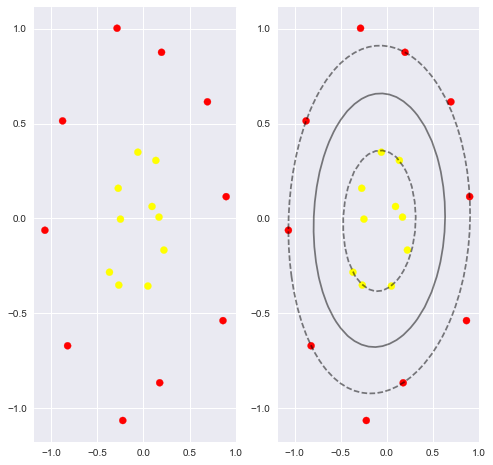

In [9]:
from sklearn.datasets.samples_generator import make_circles
Xc, yc = make_circles(20, factor=0.25, noise=.1)

model2 = SVC(kernel='rbf',C=10^6).fit(Xc, yc)

f,ax = plt.subplots(1,2)
ax[0].scatter(Xc[:, 0], Xc[:, 1], c=yc, s=50, cmap='autumn')
ax[1].scatter(Xc[:, 0], Xc[:, 1], c=yc, s=50, cmap='autumn')
plot_svc_decision_function(model2, ax=ax[1],plot_support=False) 

plt.rcParams["figure.figsize"] = [8,8]

# SVMs are sparse! 

There is even more we can say about the SVM solution. In fact, we will see that the SVM solution is determine only by a **subset** of training points, which are known as **support vectors**.

Despite we do not prove it, given the problem
\begin{align}
\mathcal{L}(\mathbf{a}) &= \sum_{i=1}^{N}a_i -\frac{1}{2}\sum_{i=1}^N \sum_{j=1}^N a_i a_j k(\mathbf{x}^{(i)},\mathbf{x}^{(j)})\\
&\text{subject to} \\
a_i&\geq 0, ~ i=1,\ldots,N\\
0 &= \sum_{i=1}^{N} a_i  t^{(i)}
\end{align}

the [**Karush-Kuhn-Tucker (KKT)**](http://www.onmyphd.com/?p=kkt.karush.kuhn.tucker) conditions require that the solution of the problem must verify the following. For $i=1,\ldots,N$,

- $a_i\geq 0$
- $t^{(i)}(y(\mathbf{x}^{(i)})-1)\geq 0$
- $a_i\left(t^{(i)}(y(\mathbf{x}^{(i)})-1)\right)=0$

If you want to understand how to prove this results, check out Appendix E in Bishop's book.

## Support Vectors

The third condition above implies that, for any point in our training set, either $a_i=0$ or $y(\mathbf{x}^{(i)})-1$. This means that either the point **do not participate in the SVM solution** or that the point lies **exactly in the margin**. Points for which $a_i>0$ are called **support vectors** and are the only ones defining the separation hyperplane and the prediction for future values!:

\begin{align}
\mathbf{w} &=\sum_{i=1}^N a_i t^{(i)} \phi(\mathbf{x}^{(i)})\\
w_0 &= \frac{1}{N_S}\sum_{i: a_i>0} \left(t^{(i)}-\sum_{j: a_j>0} a_j t^{(j)}k(\mathbf{x}^{(i)},\mathbf{x}^{(j)})\right)\\
y(\mathbf{x}^*) &= \sum_{i=1}^{N} a_i t^{(i)} k(\mathbf{x}^{(i)},\mathbf{x}^*)+w_0
\end{align}

The fraction of support vectors w.r.t. to the total number of training points must be read as a measure of the complexity of the model and how much it is exposed to **overfitting**. The more we have, the poorest generalization we can expect.

Lets plot the support vectors in the two examples we have done before.

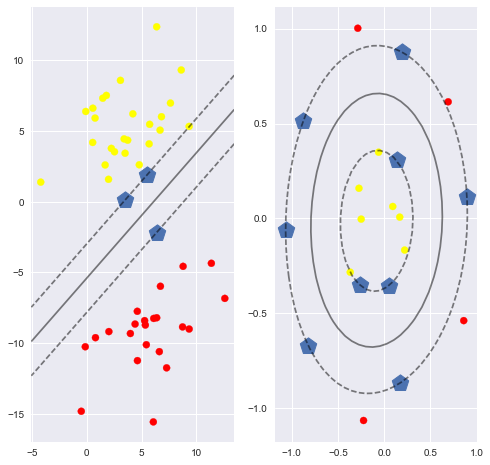

In [10]:
f,ax = plt.subplots(1,2)

ax[0].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model, ax=ax[0],plot_support=True)

ax[1].scatter(Xc[:, 0], Xc[:, 1], c=yc, s=50, cmap='autumn')
plot_svc_decision_function(model2, ax=ax[1],plot_support=True)


# Dealing with Non-separable datasets

So far, the whole SVM formulation builds up over the assumption that the data is separable by an hyperplane in a transformed space. I.e., that there exists an hyperplane $y(\mathbf{x}) = \mathbf{w}^T\phi(\mathbf{x})+w_0=0$ that verifies
\begin{align}
t^{(i)}y(\mathbf{x}^{(i)})\geq 1, ~~ \forall (\mathbf{x}^{(i)},t^{(i)}),
\end{align}
where points with equality are the support vectors. 

In order to **relax** this assumption and prevent **overfitting**, we could allow certain **training** points to be missclassified. We introduce the so-called **slack** variables:

\begin{align}
t^{(i)}y(\mathbf{x}^{(i)})\geq 1-\xi_i, ~~ \forall (\mathbf{x}^{(i)},t^{(i)})
\end{align}
where $\xi_i\geq 0$:
- Training points for which $\xi_i\leq 1$ are correctly classified.
- Training points for which $\xi_i > 1$ are in the wrong side of the decision boundary $y(\mathbf{x})=0$.

## Optimization problem with slack variables

The optimization problem can now be written as follows:
\begin{align}
&\min_{\mathbf{w},w_0} = \frac{1}{2} ||\mathbf{w}||^2_2 + C \sum_{i=1}^{N}\xi_i\\
&\text{subject to}\\
&t^{(i)}y(\mathbf{x}^{(i)})\geq 1-\xi_i, ~ i=1,\ldots,N\\
&\xi_i\geq 0, ~ i=1,\ldots,N
\end{align}
where note that the regularization is controlled by the $C$ parameter. For $C\rightarrow\infty$ we recover the original problem, as the only solution tends to $\xi_i=0$ for $i=1,\ldots,N$, and the original SVM formulation is recovered.

The Lagrange function to be optimized is now

\begin{align}
\mathcal{L}(\mathbf{w},w_0,\mathbf{a},\mathbf{b}) = \frac{||\mathbf{w}||^2_2}{2} + C \sum_{i=1}^{N}\xi_i -\sum_{i=1}^N a_i (t^{(i)}y(\mathbf{x}^{(i)})-1+\xi_i)-\sum_{i=1}^{N}b_i\xi_i,
\end{align}

### KKT conditions

The KKT conditions associated to the new optimization problem are as follows. For $i=1,\ldots,N$

$$\xi_n\geq 0$$

$$a_i\geq 0$$

$$b_i\geq 0$$

$$t^{(i)} (\mathbf{w}^T \phi(\mathbf{x})+b)-1+\xi_n)\geq 0$$

$$b_i\xi_n=0$$

$$a_i\left[t^{(i)} (y(\mathbf{x})-1+\xi_n)\right]=0$$

### Support Vectors

As before, the last condition implies that, for any point in our training set, either $a_i=0$ or $y(\mathbf{x}^{(i)})-1$. This means that either the point **do not participate in the SVM solution** or that the point lies **exactly in the margin**. Points for which $a_i>0$ are called **support vectors** and are the only ones defining the separation hyperplane and the prediction for future values!

### Dual problem

If we compute the gradient Lagrange function w.r.t. $\mathbf{w}$, $w_0$ and $\xi_i$ and equalize to zero we get the following conditions

\begin{align}
\mathbf{w} &=\sum_{i=1}^N a_i t^{(i)} \phi(\mathbf{x}^{(i)}), ~~~~~~
0 = \sum_{i=1}^{N} a_i  t^{(i)}, ~~~~~~~ a_i = C-b_i
\end{align}

If we substitute them in the Lagrange function, we derive the dual optimization problem, with complexity $\mathcal{O}(N^3)$.

Lets play with parameter $C$ with another example

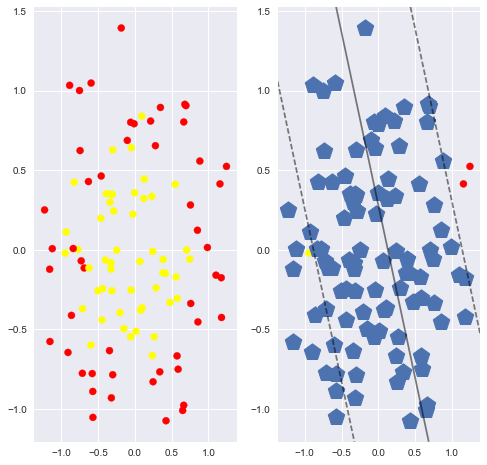

In [11]:
X, y = make_circles(100, factor=0.5, noise=.2)

model_lin = SVC(kernel='linear',C=10^8 ).fit(X, y)

f,ax = plt.subplots(1,2)

ax[0].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
ax[1].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model_lin, ax=ax[1],plot_support=True) # Try to plot the suppor vectors by changing the flag

plt.rcParams["figure.figsize"] = [8,8]

Clearly, a linear Kernel does not do the job

In [12]:
model_rbf = SVC(kernel='rbf',C=1e6).fit(X, y)

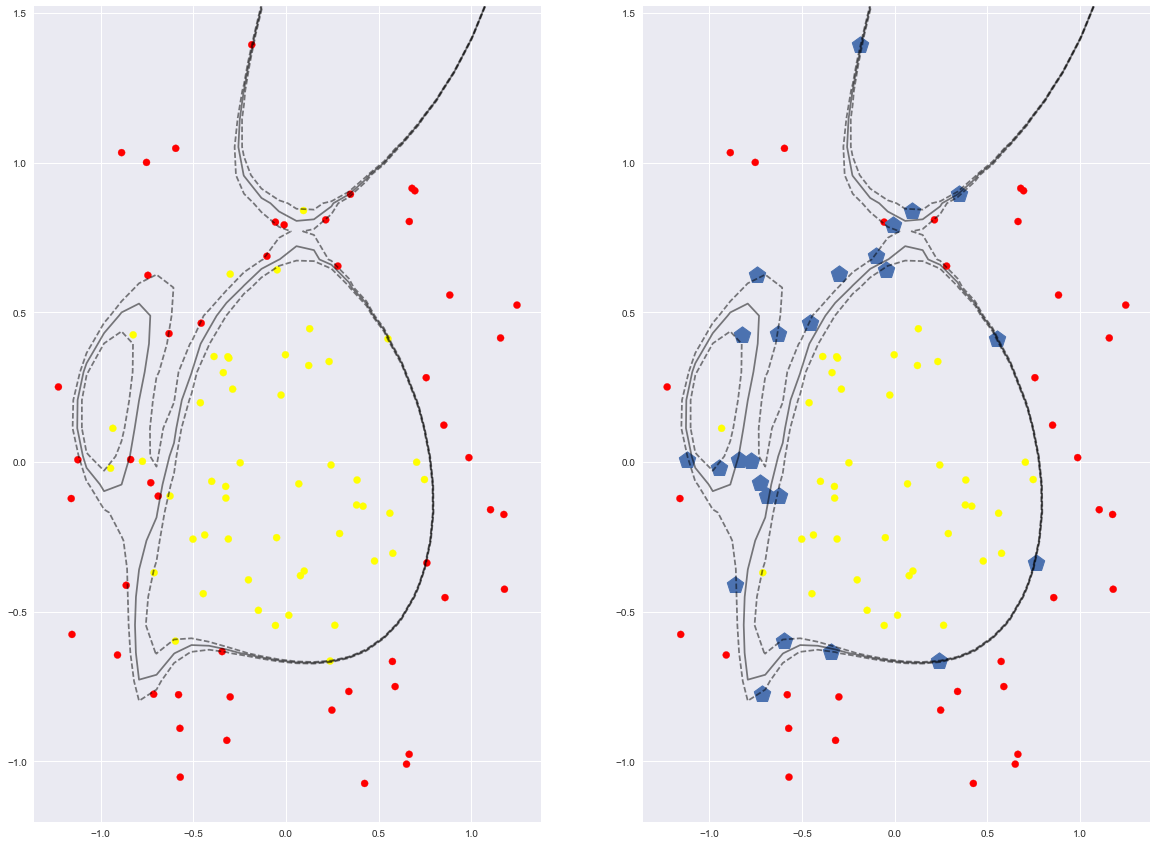

In [16]:
f, axes = plt.subplots(1, 2)
axes[0].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model_rbf ,ax=axes[0], plot_support=False) 
axes[1].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model_rbf ,ax=axes[1], plot_support=True) 


plt.rcParams["figure.figsize"] = [20,15]

And now with $C=10$ ...

In [14]:
model_rbf_2 = SVC(kernel='rbf',C=1e1).fit(X, y)

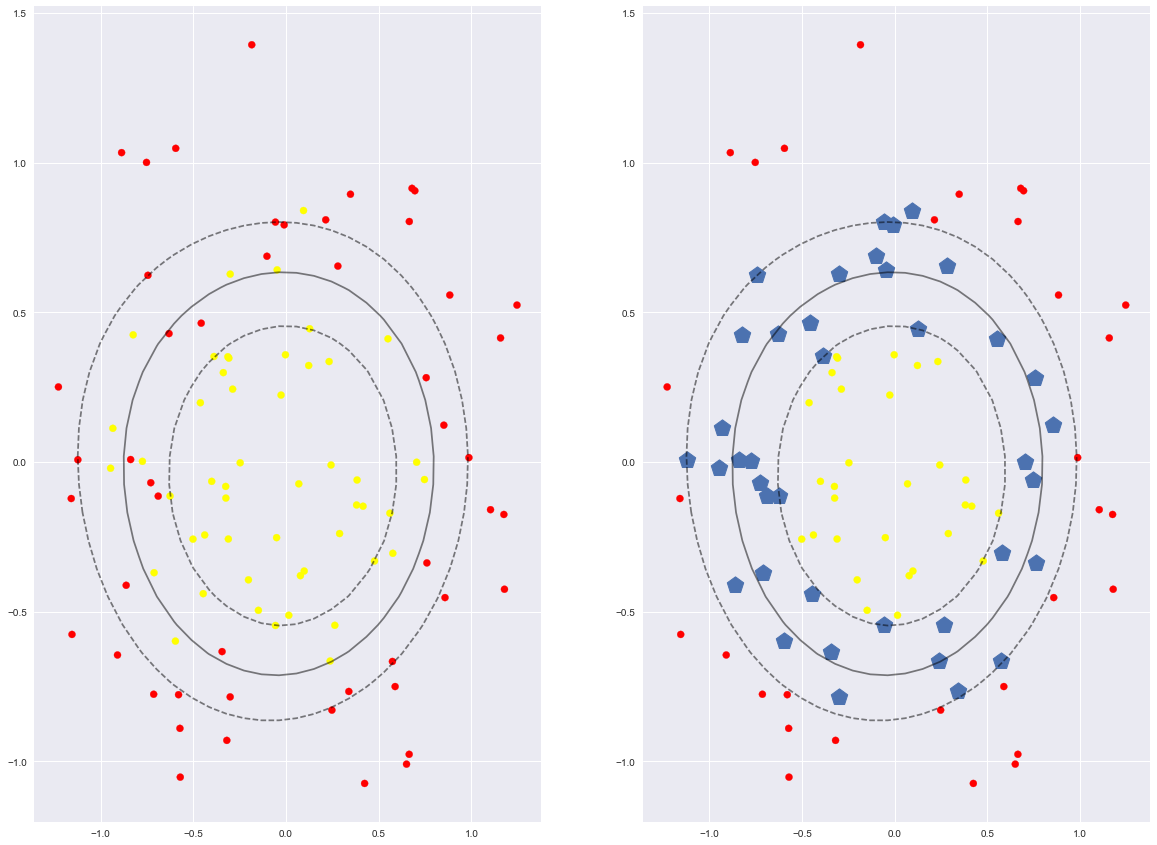

In [15]:
f, axes = plt.subplots(1, 2)
axes[0].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model_rbf_2,ax=axes[0], plot_support=False) 
axes[1].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model_rbf_2,ax=axes[1], plot_support=True) 